<a href="https://colab.research.google.com/github/rlathwls03/sensor-activity-classifier/blob/main/2_%EA%B8%B0%EB%B3%B8_%EB%AA%A8%EB%8D%B8%EB%A7%81.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**스마트폰 센서 데이터 기반 모션 분류**
# 단계2 : 기본 모델링


## 0.미션3

* 데이터 전처리
    * 가변수화, 데이터 분할, NaN 확인 및 조치, 스케일링 등 필요한 전처리 수행
* 다양한 딥러닝 구조의 모델로 분류 모델 생성
    * 최소 4개 이상 모델링 수행
    * 각 모델별 최소 5회 반복수행해서 얻은 성능의 평균으로 비교
    * 각 모델의 성능을 저장하는 별도 데이터 프레임을 만들고 비교
* 옵션 : 다음 사항은 선택사항입니다. 시간이 허용하는 범위 내에서 수행하세요.
    * 상위 N개 변수를 선정하여 모델링 및 성능 비교
        * 모델링에 항상 모든 변수가 필요한 것은 아닙니다.
        * 변수 중요도 상위 N개를 선정하여 모델링하고 타 모델과 성능을 비교하세요.
        * 상위 N개를 선택하는 방법은, 변수를 하나씩 늘려가며 모델링 및 성능 검증을 수행하여 적절한 지점을 찾는 것입니다.
* 성능 가이드
    * Accuracy : 0.90 ~ 0.99

## 1.환경설정

* 세부 요구사항
    - 경로 설정 : 구글콜랩
        * 구글 드라이브 바로 밑에 project1 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### (1) 경로 설정

* 구글 드라이브 연결

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/project2/'

%cd '/content/drive/MyDrive/project2/'
!ls

/content/drive/MyDrive/project2
'1.탐색적 데이터 분석.ipynb'	        data01_train.csv
'1.탐색적 데이터 분석_추가과제.ipynb'   desktop.ini
'2.기본 모델링.ipynb'		        feature_importance_all.pkl
'3.단계별 모델링.ipynb'		        features.csv
'AI 미프 1차 과제2_OO반_OO조.pptx'     'features 설명.xlsx'
 data01_test.csv


### (2) 라이브러리 불러오기

* 라이브러리 로딩
     - pandas, numpy,matplotlib,seaborn, joblib, 모델링에 필요한 라이브러리를 로딩합니다.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import *

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input
from tensorflow.keras.backend import clear_session
from tensorflow.keras.optimizers import Adam

In [ ]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (3) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
    * data01_test.csv : 테스트용
    * feature.csv : feature 이름을 계층구조로 정리한 데이터

* 세부 요구사항
    * 칼럼 삭제 : data01_train.csv와 data01_test.csv 에서 'subject' 칼럼은 불필요하므로 삭제합니다.

#### 1) 데이터로딩

In [ ]:
# 주어진 데이터 셋을 불러오세요.(3개)
train = pd.read_csv('data01_train.csv')
test = pd.read_csv('data01_test.csv')
features = pd.read_csv('features.csv')

In [ ]:
#불필요한 칼럼을 삭제하세요. (subject)

In [ ]:
for df in (train, test):
  if 'subject' in df.columns:
    df.drop(columns=['subject'], inplace=True)

train.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.004012,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.157832,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS


#### 2) 기본 정보 조회

In [ ]:
#전체 데이터의 행,열 개수 확인
print("train 데이터의 shape:", train.shape)
print("test 데이터의 shape:", test.shape)

train 데이터의 shape: (5881, 562)
test 데이터의 shape: (1471, 562)


In [ ]:
#전체 데이터의 상위 5개 행 확인
train.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.004012,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.157832,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS


In [ ]:
#전체 데이터의 수치형 변수 분포 확인
train.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,...,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000
mean,0.274811,-0.017799,-0.109396,-0.603138,-0.509815,-0.604058,-0.628151,-0.525944,-0.605374,-0.465490,...,0.126955,-0.305883,-0.623548,0.008524,-0.001185,0.009340,-0.007099,-0.491501,0.059299,-0.054594
std,0.067614,0.039422,0.058373,0.448807,0.501815,0.417319,0.424345,0.485115,0.413043,0.544995,...,0.249176,0.322808,0.310371,0.339730,0.447197,0.608190,0.476738,0.509069,0.297340,0.278479
min,-0.503823,-0.684893,-1.000000,-1.000000,-0.999844,-0.999667,-1.000000,-0.999419,-1.000000,-1.000000,...,-0.965725,-0.979261,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.980143
25%,0.262919,-0.024877,-0.121051,-0.992774,-0.977680,-0.980127,-0.993602,-0.977865,-0.980112,-0.936067,...,-0.021610,-0.541969,-0.845985,-0.122361,-0.294369,-0.481718,-0.373345,-0.811397,-0.018203,-0.141555
50%,0.277154,-0.017221,-0.108781,-0.943933,-0.844575,-0.856352,-0.948501,-0.849266,-0.849896,-0.878729,...,0.133887,-0.342923,-0.712677,0.010278,0.005146,0.011448,-0.000847,-0.709441,0.182893,0.003951
75%,0.288526,-0.010920,-0.098163,-0.242130,-0.034499,-0.262690,-0.291138,-0.068857,-0.268539,-0.013690,...,0.288944,-0.127371,-0.501158,0.154985,0.285030,0.499857,0.356236,-0.511330,0.248435,0.111932
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.946700,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,0.977344,0.478157,1.000000


In [ ]:
#전체 데이터의 모든 변수 확인
print(train.info())
print('-'*30)
print(train.columns)

print('-'*30)
print(test.columns)

print('-'*30)
print(features.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5881 entries, 0 to 5880
Columns: 562 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), object(1)
memory usage: 25.2+ MB
None
------------------------------
Index(['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z',
       'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z',
       'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z',
       'tBodyAcc-max()-X',
       ...
       'fBodyBodyGyroJerkMag-skewness()', 'fBodyBodyGyroJerkMag-kurtosis()',
       'angle(tBodyAccMean,gravity)', 'angle(tBodyAccJerkMean),gravityMean)',
       'angle(tBodyGyroMean,gravityMean)',
       'angle(tBodyGyroJerkMean,gravityMean)', 'angle(X,gravityMean)',
       'angle(Y,gravityMean)', 'angle(Z,gravityMean)', 'Activity'],
      dtype='object', length=562)
------------------------------
Index(['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z',
       'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z',
  

## **2. 데이터 전처리**

* 가변수화, 데이터 분할, NaN 확인 및 조치, 스케일링 등 필요한 전처리를 수행한다.


### (1) 데이터 분할1 : x, y

* 세부 요구사항
    - x, y로 분할합니다.

In [ ]:
# 데이터 분할을 합니다.
x = train.drop('Activity', axis=1)
y = train['Activity']

### (2) Y 전처리
* integer encoding : LabelEncoder
* (필요시) one-hot encoding

In [ ]:
# 정수 인코딩 변환(LabelEncoder)
le = LabelEncoder()
y = le.fit_transform(y)

In [ ]:
# 기존 레이블 저장
label_map = dict(zip(le.classes_, range(len(le.classes_))))
label_map

{'LAYING': 0,
 'SITTING': 1,
 'STANDING': 2,
 'WALKING': 3,
 'WALKING_DOWNSTAIRS': 4,
 'WALKING_UPSTAIRS': 5}

### (3) 데이터분할2 : train, validation

* 세부 요구사항
    - train : val = 8 : 2 혹은 7 : 3
    - random_state 옵션을 사용하여 다른 모델과 비교를 위해 성능이 재현되도록 합니다.

In [ ]:
#데이터 분할 진행(train:val = 8:2 혹은 7:3 권장)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

### (4) 스케일링


* 세부 요구사항
    - 스케일링을 필요로 하는 알고리즘 사용을 위해서 코드 수행
    - min-max 방식 혹은 standard 방식 중 한가지 사용.

In [ ]:
#스케일링 방식을 선택해서 스케일링을 진행합니다.
# MinMaxScaler

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)

## **3. 기본 모델링**



* 세부 요구사항
    - 모델1 : Base line 모델
        * Hidden Layer 없이 모델 생성
    - 모델2 : 복잡한 모델 생성
        * 최소 5개 이상의 은닉층을 추가한 모델
    - 모델3 ~ n : 튜닝 모델
        * 학습률, epoch 등 조정
        * 모델2에 과적합을 방지하기 위한 규제 기법 추가
        * Accuracy 최대화 시키는 모델 생성하기
    - (옵션) 각 모델은 최소 5번 반복수행해서 얻은 성능의 평균값을 기록

### (1) 모델1 : Hidden Layer 없이 모델 생성

In [ ]:
# 모델 설계
clear_session()

nfeatures = x_train.shape[1]
n_classes  = len(np.unique(y_train))

model = Sequential([
    Input(shape=(nfeatures, )),
    Dense(n_classes, activation='softmax')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 6)              │         3,372 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,372 (13.17 KB)

 Trainable params: 3,372 (13.17 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 컴파일 및 학습
model.compile(optimizer=Adam(learning_rate=0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'] )

hist = model.fit(x_train, y_train, epochs=100, validation_split=0.2, verbose=0).history

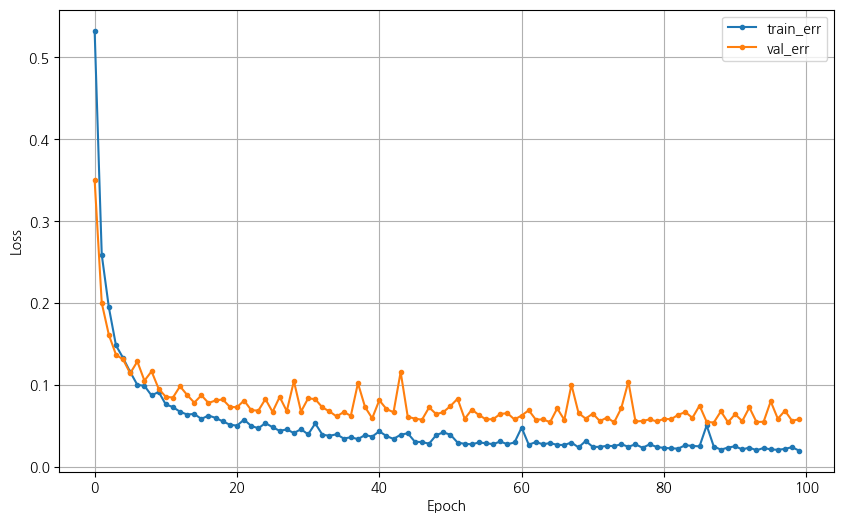

In [ ]:
# 학습곡선
dl_history_plot(hist)

In [ ]:
# 예측 및 평가
y_pred = model.predict(x_val)
print(y_pred[:5])

y_pred = np.argmax(y_pred, axis=1)
print(y_pred[:5])

print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[[9.9968755e-01 3.1242543e-04 8.1071129e-14 2.8549120e-17 5.8012534e-19
  3.0519599e-15]
 [2.2552591e-03 9.9774480e-01 8.9787199e-11 1.6253812e-09 2.2497412e-21
  2.7169197e-19]
 [5.2995104e-14 6.9952981e-11 1.0226047e-17 9.9999994e-01 3.8971568e-10
  1.1308659e-08]
 [9.9994344e-01 5.6455650e-05 1.1531422e-16 3.1882042e-17 9.7329169e-22
  3.2022895e-20]
 [4.1962690e-07 9.0910739e-01 9.0891361e-02 7.7417906e-07 1.9003451e-15
  1.0614102e-18]]
[0 1 3 0 1]
[[223   0   0   0   0   0]
 [  1 187  17   0   0   1]
 [  0   3 215   0   0   0]
 [  0   0   0 200   0   0]
 [  0   0   0   0 158   0]
 [  0   0   0   1   0 171]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       223
           1       0.98      0.91      0.94       206
           2       0.93      0.99      0.96       218
           3       1.00      1.00      1.00       200
           4       1.00      1.00      1.00       158
           5   

In [ ]:
#(옵션) 모델1번을 최소 5번 반복수행해서 얻은 성능의 평균값을 기록해보자!

### (2) 모델2 : 최소 5개 이상의 은닉층을 추가한 모델

In [ ]:
# 모델 설계
clear_session()

nfeatures = x_train.shape[1]
n_classes  = len(np.unique(y_train))

model2 = Sequential([
    Input(shape=(nfeatures, )),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(n_classes, activation='softmax')
])

model2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │       143,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 203,814 (796.15 KB)

 Trainable params: 203,814 (796.15 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 컴파일 및 학습
model2.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'] )

hist = model2.fit(x_train, y_train, epochs=150, validation_split=0.2, verbose=0).history

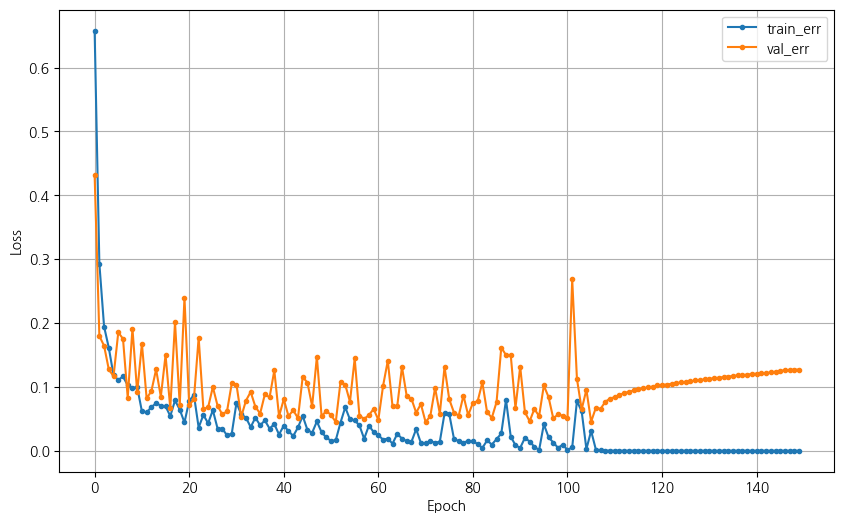

In [ ]:
# 학습곡선
dl_history_plot(hist)

In [ ]:
# 예측 및 평가
y_pred = model2.predict(x_val)
print(y_pred[:5])

y_pred = np.argmax(y_pred, axis=1)
print(y_pred[:5])

print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
[[9.9999994e-01 4.0879103e-10 2.2000425e-19 6.5149907e-18 1.3560871e-15
  2.0112273e-16]
 [0.0000000e+00 9.9999994e-01 1.4106362e-28 0.0000000e+00 0.0000000e+00
  2.1460459e-28]
 [1.3139206e-27 5.9522335e-17 8.2378020e-16 9.9999994e-01 3.2996085e-11
  5.2004869e-11]
 [9.9999994e-01 5.6816318e-10 2.5988384e-19 7.3977310e-18 1.3975443e-15
  1.9697852e-16]
 [8.2321305e-20 9.9999994e-01 3.1518939e-13 9.3142876e-20 1.5721764e-23
  6.3182322e-14]]
[0 1 3 0 1]
[[223   0   0   0   0   0]
 [  1 193  11   0   0   1]
 [  0   4 214   0   0   0]
 [  0   0   0 200   0   0]
 [  0   0   0   0 157   1]
 [  0   0   0   0   2 170]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       223
           1       0.98      0.94      0.96       206
           2       0.95      0.98      0.97       218
           3       1.00      1.00      1.00       200
           4       0.99      0.99      0.99       158
           5   

### (3) 모델3 : 학습률, epoch 등 조정

In [ ]:
# 모델 설계
clear_session()

nfeatures = x_train.shape[1]
n_classes  = len(np.unique(y_train))

model3 = Sequential([
    Input(shape=(nfeatures, )),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(n_classes, activation='softmax')
])

model3.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │       143,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 203,814 (796.15 KB)

 Trainable params: 203,814 (796.15 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 컴파일 및 학습
model3.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'] )

hist = model3.fit(x_train, y_train, epochs=300, validation_split=0.2, verbose=0).history

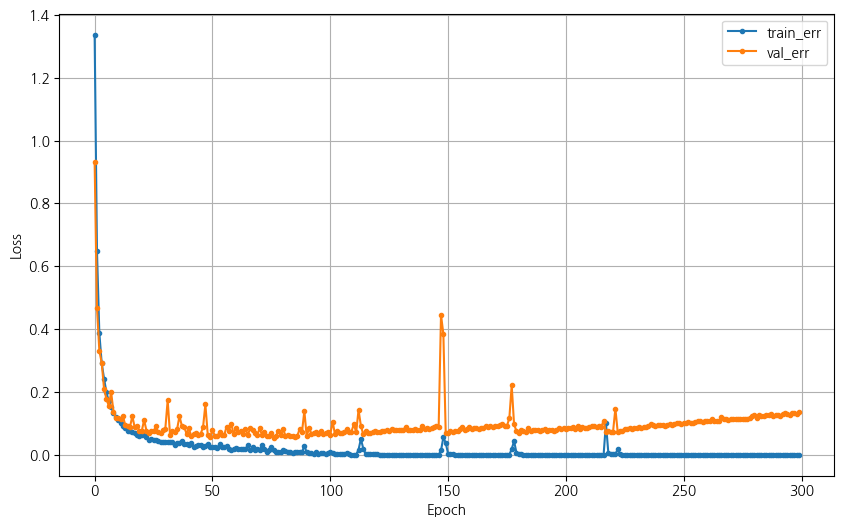

In [ ]:
# 학습곡선
dl_history_plot(hist)

In [ ]:
# 예측 및 평가
y_pred = model3.predict(x_val)
print(y_pred[:5])

y_pred = np.argmax(y_pred, axis=1)
print(y_pred[:5])

print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
[[9.9999982e-01 7.0052018e-08 3.3522929e-29 1.0496034e-22 3.0743197e-10
  3.4966596e-11]
 [9.6836028e-10 9.9999994e-01 1.3639019e-20 5.5557346e-18 4.2022671e-13
  4.4391066e-12]
 [1.5562107e-21 4.7395586e-12 3.8163552e-12 9.9999994e-01 4.3486373e-10
  5.0513944e-09]
 [9.9999994e-01 4.3002397e-09 3.3635331e-33 9.9760971e-26 2.7066569e-11
  8.0113954e-13]
 [1.0822746e-08 9.9999994e-01 3.1926586e-08 1.6293432e-10 1.9362902e-08
  1.8067050e-08]]
[0 1 3 0 1]
[[223   0   0   0   0   0]
 [  0 196   9   0   0   1]
 [  0   8 210   0   0   0]
 [  0   0   0 198   2   0]
 [  0   0   0   0 158   0]
 [  0   0   0   1   0 171]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       223
           1       0.96      0.95      0.96       206
           2       0.96      0.96      0.96       218
           3       0.99      0.99      0.99       200
           4       0.99      1.00      0.99       158
           5   

### (4) 모델4 :  학습률, epoch 등 조정

In [ ]:
# 모델 설계
clear_session()

nfeatures = x_train.shape[1]
n_classes  = len(np.unique(y_train))

model4 = Sequential([
    Input(shape=(nfeatures, )),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(n_classes, activation='softmax')
])

model4.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │       143,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 203,814 (796.15 KB)

 Trainable params: 203,814 (796.15 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 컴파일 및 학습
model4.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'] )

hist = model4.fit(x_train, y_train, epochs=50, validation_split=0.2, verbose=0).history

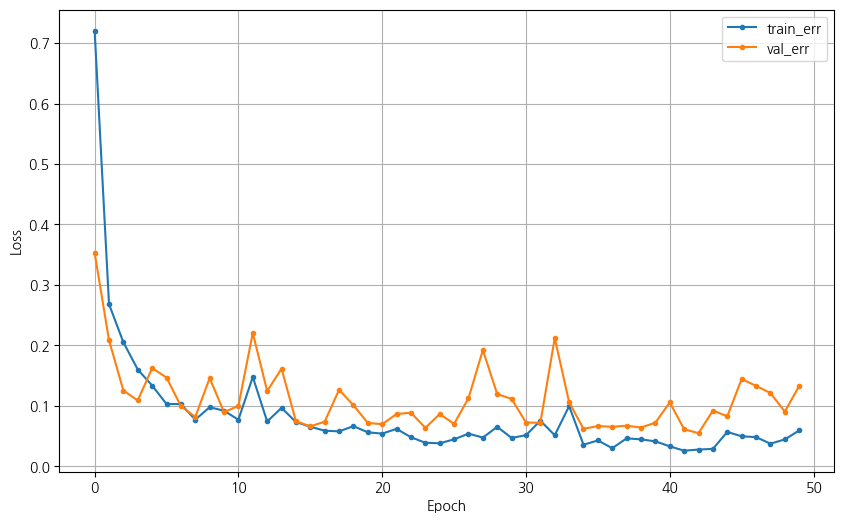

In [ ]:
# 학습곡선
dl_history_plot(hist)

In [ ]:
# 예측 및 평가
y_pred = model4.predict(x_val)
print(y_pred[:5])

y_pred = np.argmax(y_pred, axis=1)
print(y_pred[:5])

print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
[[9.9995869e-01 4.1064763e-05 1.1541018e-08 8.7269676e-09 5.4579320e-11
  2.6268563e-07]
 [1.6447570e-03 9.9834126e-01 1.2473868e-05 3.2807097e-08 1.4292524e-07
  1.4516859e-06]
 [1.1239290e-10 1.6911084e-11 3.1597047e-09 9.9999720e-01 9.4509524e-08
  2.5862762e-06]
 [9.9999517e-01 4.7990743e-06 5.5517169e-10 4.1328288e-10 6.2181754e-13
  8.8090326e-09]
 [1.8737812e-03 9.9747044e-01 6.2153832e-04 1.7440076e-06 1.4271400e-05
  1.8164350e-05]]
[0 1 3 0 1]
[[223   0   0   0   0   0]
 [  1 198   1   0   0   6]
 [  0   9 200   0   0   9]
 [  0   0   0 183   3  14]
 [  0   0   0   0 158   0]
 [  0   0   0   0   0 172]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       223
           1       0.96      0.96      0.96       206
           2       1.00      0.92      0.95       218
           3       1.00      0.92      0.96       200
           4       0.98      1.00      0.99       158
           5   

## 4.성능비교

* 세부 요구사항
    - test 데이터에 대한 전처리
    - 각 모델에 대해서 test 데이터로 성능 측정

In [ ]:
#전체 데이터 불러오기(test)
test = pd.read_csv('data01_test.csv')

# subject 삭제
if 'subject' in test.columns:
    test.drop('subject', axis=1, inplace=True)

# x, y 분할
x_test = test.drop('Activity', axis=1)
y_test = test['Activity'].copy()

# y : 정수인코딩 적용
# y: LabelEncoder 적용
# (train에서 이미 fit된 le 사용)
y_test = le.transform(y_test)

# x : 스케일링 적용
# (train에서 fit된 scaler 사용)
x_test = scaler.transform(x_test)

In [ ]:
# 한글 표시를 위해 설치
!pip install koreanize_matplotlib -q
import koreanize_matplotlib

,Model,Test Accuracy,Loss
0,model1,0.953773,0.159872
1,model2,0.985044,0.161991
2,model3,0.980286,0.144677
3,model4,0.953773,0.159872


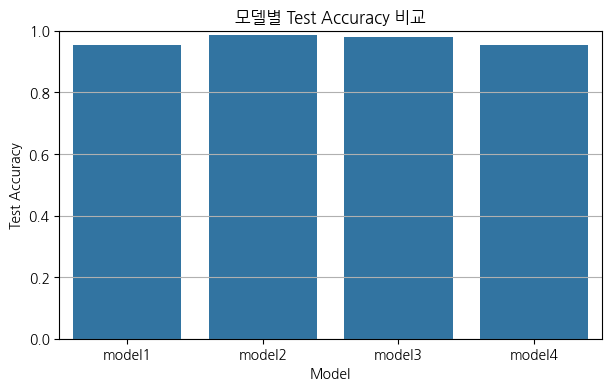

In [ ]:
# test 데이터에 대한 성능 측정
# model1, model2, model3, model4를 x_test, y_test로 평가
#.evaluate()는 Keras 모델에서 (loss, accuracy) 반환
#결과를 DataFrame으로 정리해 시각화 및 비교
results = []

for i, model in enumerate([model, model2, model3, model4], start=1):
    loss, acc = model.evaluate(x_test, y_test, verbose=0)
    results.append({'Model': f'model{i}', 'Test Accuracy': acc, 'Loss': loss})

results_df = pd.DataFrame(results)
display(results_df)


# 시각화 (옵션)
plt.figure(figsize=(7, 4))
sns.barplot(x='Model', y='Test Accuracy', data=results_df)
plt.title('모델별 Test Accuracy 비교')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()

#### 고생하셨습니다! 이제 단계적 모델링을 해봅시다.